In [ ]:
import zipfile
import os

# ZIP dosyanın Colab içindeki yolu (Dosyanı yüklediğin yer burası olmalı)
zip_path = "/content/drive/MyDrive/Beyin_Verileri_Teknofest_2021/beyin_verileri.zip"

# ZIP dosyasını çıkaracağımız hedef klasör
extract_path = "/content/beyin_verileri"

# ZIP dosyasını çıkar
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)  # Kendi klasörünü oluştur

print("ZIP dosyası çıkarıldı.")

# Çıkarılan klasör içeriğini kontrol et
print(os.listdir(extract_path))
print("Train klasörü:", os.listdir(os.path.join(extract_path, "train")))
print("Val klasörü:", os.listdir(os.path.join(extract_path, "val")))
print("Test klasörü:", os.listdir(os.path.join(extract_path, "test")))

ZIP dosyası çıkarıldı.
['train', 'test', 'val']
Train klasörü: ['inme_var', 'inme_yok']
Val klasörü: ['inme_var', 'inme_yok']
Test klasörü: ['inme_var', 'inme_yok']


In [ ]:
import numpy as np
import cv2
import os
from tensorflow.keras.applications.efficientnet import preprocess_input

# EfficientNetB2 için uygun görüntü boyutu
img_size = (260, 260)

# Veri yükleme fonksiyonu (EfficientNetB2 için)
def load_dataset(dataset_type="train", limit=None):
    X, Y = [], []
    classes = ["inme_var", "inme_yok"]

    dataset_path = f"/content/beyin_verileri/{dataset_type}"

    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset path '{dataset_path}' not found!")

    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)

        if not os.path.exists(class_path):
            print(f"Warning: Class path '{class_path}' not found! Skipping...")
            continue

        image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.png')]

        if not image_files:
            print(f"Warning: No images found in {class_path}")

        if limit:
            image_files = image_files[:limit]

        for file in image_files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Warning: Could not read image {file}. Skipping...")
                continue

            # Gri tonlamalıyı 3 kanallıya çevir
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            # EfficientNetB2 boyutuna yeniden boyutlandır
            img = cv2.resize(img, img_size)

            # Normalizasyon (0-1 arasına getir)
            img = img / 255.0

            # EfficientNet’in preprocess_input fonksiyonu kullanılabilir (Opsiyonel)
            # img = preprocess_input(img)

            X.append(img)
            Y.append(label)

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.int32)

# EfficientNetB2 için Train, Validation ve Test veri setlerini yükleme
X_train, Y_train = load_dataset("train")
X_val, Y_val = load_dataset("val")
X_test, Y_test = load_dataset("test")

# Veri boyutlarını kontrol et
print(f"Train Set: {X_train.shape}, Labels: {Y_train.shape}")
print(f"Validation Set: {X_val.shape}, Labels: {Y_val.shape}")
print(f"Test Set: {X_test.shape}, Labels: {Y_test.shape}")


Train Set: (4654, 260, 260, 3), Labels: (4654,)
Validation Set: (997, 260, 260, 3), Labels: (997,)
Test Set: (999, 260, 260, 3), Labels: (999,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Modelin giriş boyutu
input_shape = (260, 260, 3)

# EfficientNetB2 temel modeli (pretrained)
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = True  # Temel modelin tamamını eğitilebilir yap
fine_tune_at = 100  # Son 100 katmanı eğitilebilir yap

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False  # İlk katmanları dondur

# Yeni başlık katmanları ekleme
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)  # Eğitim sırasında temel modelin durumunu koru
x = GlobalAveragePooling2D()(x)  # Özellikleri sıkıştır
x = BatchNormalization()(x)  # Batch Normalization ekle
x = Dense(128, activation="relu")(x)  # Tam bağlı katman
x = BatchNormalization()(x)  # Batch Normalization ekle
x = Dropout(0.3)(x)  # Overfitting'i önlemek için Dropout ekle
x = Dense(64, activation="relu")(x)  # Daha küçük bir Dense katmanı
x = BatchNormalization()(x)  # Batch Normalization ekle
x = Dropout(0.3)(x)  # Yine Dropout ekle
outputs = Dense(1, activation="sigmoid")(x)  # 1 çıkış bir sigmoid aktivasyonu ile

# Modeli oluştur
model = Model(inputs, outputs)

# Modeli derle (Precision & Recall metriklerini ekledik)
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="binary_crossentropy",  # binary_crossentropy kaybı kullanacağız
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Model özetini yazdır
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 260, 260, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb2 (Functional)          │ (None, 9, 9, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 1408)                │           5,632 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,963,642 (30.38 MB)

 Trainable params: 7,802,725 (29.77 MB)

 Non-trainable params: 160,917 (628.59 KB)

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback

# Google Drive içindeki kayıt klasörü
model_save_dir = "/content/drive/MyDrive/Model_Kayitlar/EfficientB2/"


# Callback'leri liste olarak tanımla
callbacks_list = [
    ModelCheckpoint(
        os.path.join(model_save_dir, "BestEfficientB2_model.keras"),  # En iyi modeli kaydet
        monitor="val_loss",  # Validasyon kaybını izle
        save_best_only=True,  # Sadece en iyi modeli kaydet
        save_weights_only=False,  # Modelin tamamını kaydet (ağırlıklar + yapı)
        mode="min",  # En düşük val_loss olduğunda kaydet
        verbose=1
    ),
    LambdaCallback(
        on_epoch_end=lambda epoch, logs: model.save(os.path.join(model_save_dir, f"model_epoch_{epoch+1:02d}.keras")) if (epoch + 1) % 25 == 0 else None
    ),
    EarlyStopping(
        monitor="val_loss",  # Validasyon kaybını izle
        patience=5,  # 5 epoch boyunca iyileşme olmazsa dur
        mode="min",  # En düşük val_loss değerini takip et
        verbose=1,
        restore_best_weights=True  # En iyi ağırlıklara geri dön
    ),
    ReduceLROnPlateau(
        monitor="val_loss",  # Validasyon kaybını izle
        factor=0.5,
        patience=5,  # 3 epoch boyunca iyileşme olmazsa azalt
        mode="min",  # En düşük val_loss değerini takip et
        verbose=1,
        min_lr=1e-6  # Minimum öğrenme hızı
    )
]


In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=1000,  # Eğitim süresi
    batch_size=32,  # Mini-batch boyutu
    callbacks=callbacks_list  # Callback'leri liste olarak ekle
)


Epoch 1/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5339 - loss: 0.9080 - precision_4: 0.7035 - recall_4: 0.5371
Epoch 1: val_loss improved from inf to 0.62649, saving model to /content/drive/MyDrive/Model_Kayitlar/EfficientB2/BestEfficientB2_model.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 167s 492ms/step - accuracy: 0.5340 - loss: 0.9078 - precision_4: 0.7035 - recall_4: 0.5372 - val_accuracy: 0.6660 - val_loss: 0.6265 - val_precision_4: 0.6660 - val_recall_4: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/1000
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6085 - loss: 0.7732 - precision_4: 0.7590 - recall_4: 0.5991
Epoch 2: val_loss did not improve from 0.62649
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.6085 - loss: 0.7732 - precision_4: 0.7590 - recall_4: 0.5992 - val_accuracy: 0.6630 - val_loss: 0.6604 - val_precision_4: 0.6680 - val_recall_4: 0.9819 - learning_rate: 1.0000e-05
Epoch 3/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6254 -

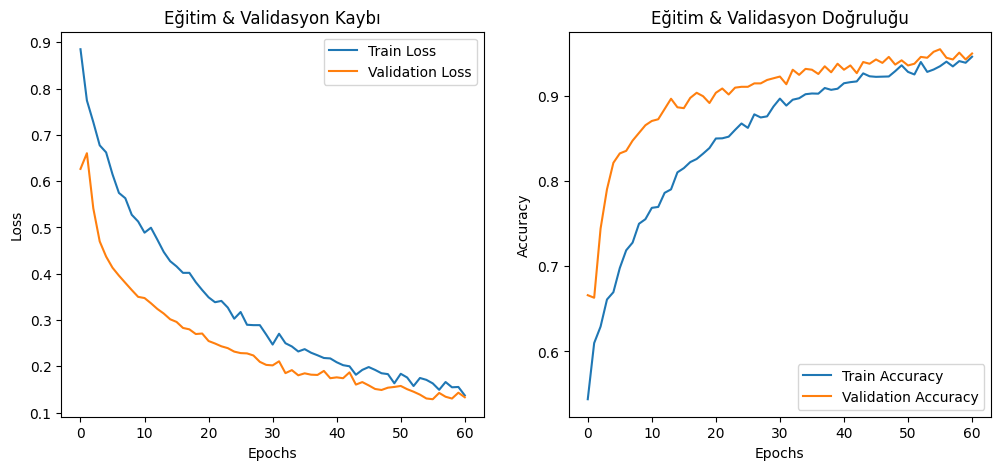

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Eğitim sonuçlarını al

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Grafik Çizme
plt.figure(figsize=(12, 5))

# Kayıp Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Eğitim & Validasyon Kaybı")
plt.legend()

# Doğruluk Grafiği
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Eğitim & Validasyon Doğruluğu")
plt.legend()

plt.show()

In [ ]:
# Test seti üzerinde modeli değerlendir
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, Y_test, verbose=1)

# Modelin tahminlerini al
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Sigmoid çıktısını sınıflara çevir

# Sonuçları yazdır
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9175 - loss: 0.2321 - precision_4: 0.5879 - recall_4: 0.6849
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step
Test Loss: 0.1757
Test Accuracy: 0.9449
Test Precision: 0.9433
Test Recall: 0.9759
